/tmp/ipython-input-1668928309.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')


Features: ['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed', 'windgust', 'sealevelpressure', 'precipprob']
Targets (model will predict): ['precip', 'humidity', 'sealevelpressure', 'windspeed', 'windgust', 'avg_temp', 'max_temp', 'min_temp']
Training samples: 1066 | Window size: 30 | Features per step: 9 | Outputs: 8

Using TensorFlow LSTM model.
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1031 - mae: 0.2464 - val_loss: 0.0282 - val_mae: 0.1288
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0325 - mae: 0.1413 - val_loss: 0.0274 - val_mae: 0.1227
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0293 - mae: 0.1314 - val_loss: 0.0266 - val_mae: 0.1247
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0274 - mae: 0.1273 - val_loss: 0.0260 - val_mae: 0.1227
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0249 - mae: 0.1205 - val_loss: 0.0259 - val_mae: 0.1233
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/

,date,precip,humidity,sealevelpressure,windspeed,windgust,avg_temp,max_temp,min_temp,rain_chance_%
0,2025-11-18,0.10,56.07,1011.32,15.00,29.54,41.48,48.82,36.11,20.00
1,2025-11-19,0.05,49.49,1013.65,15.68,29.25,37.33,42.95,30.86,10.00
2,2025-11-20,0.06,48.44,1014.73,15.89,29.09,34.43,39.61,27.84,12.00
3,2025-11-21,0.07,49.67,1014.96,15.98,29.20,32.60,38.01,26.37,14.00
4,2025-11-22,0.09,51.27,1014.76,16.02,29.44,31.70,37.63,25.97,18.00
5,2025-11-23,0.10,52.44,1014.45,16.01,29.71,31.61,38.10,26.25,20.00
6,2025-11-24,0.10,53.30,1014.18,16.00,29.99,31.78,38.68,26.70,20.00


,date,avg_temp,max_temp,min_temp
0,2025-11-18,41.48,48.82,36.11
1,2025-11-19,37.33,42.95,30.86
2,2025-11-20,34.43,39.61,27.84
3,2025-11-21,32.60,38.01,26.37
4,2025-11-22,31.70,37.63,25.97
5,2025-11-23,31.61,38.10,26.25
6,2025-11-24,31.78,38.68,26.70


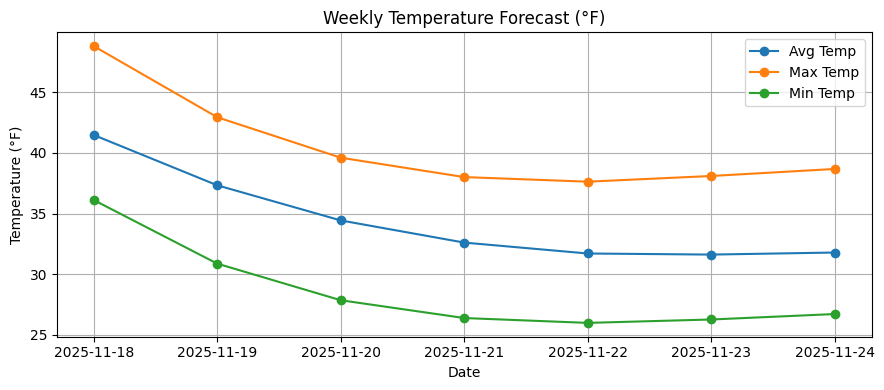

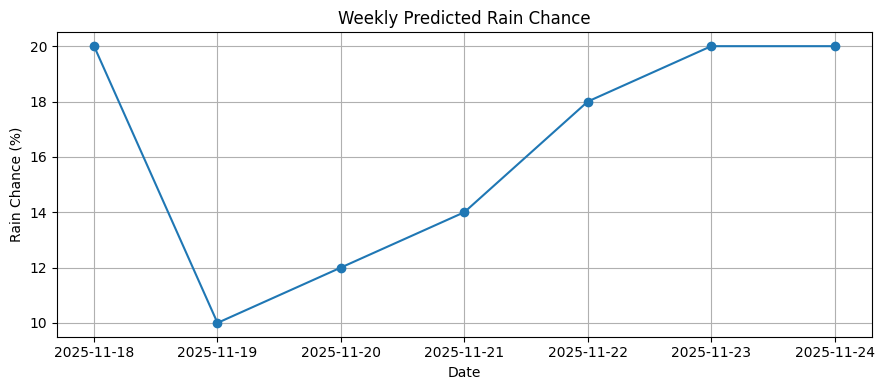

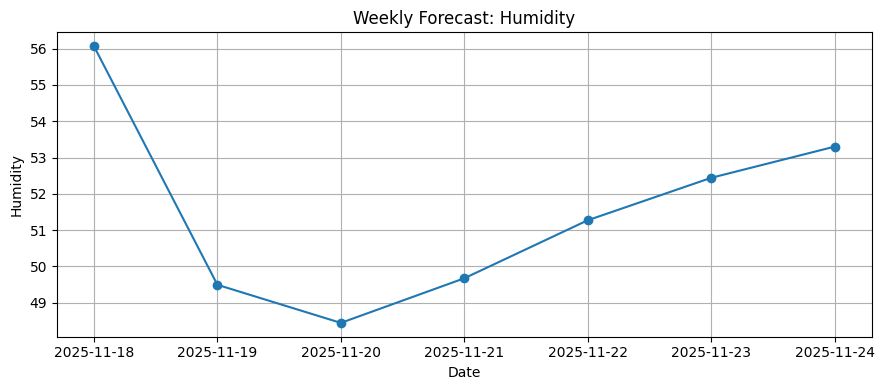

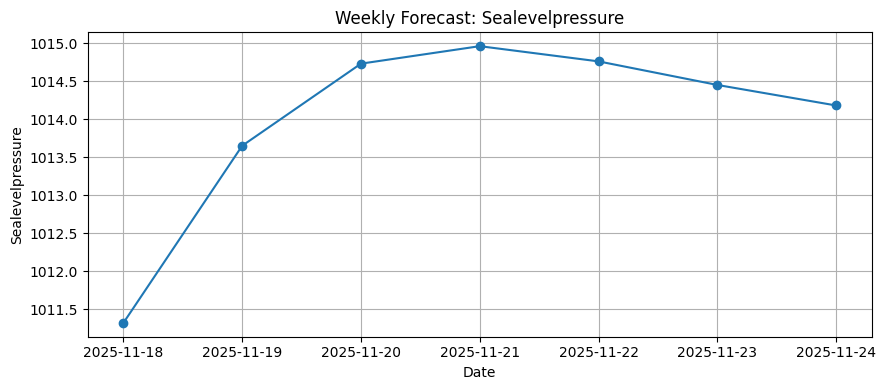

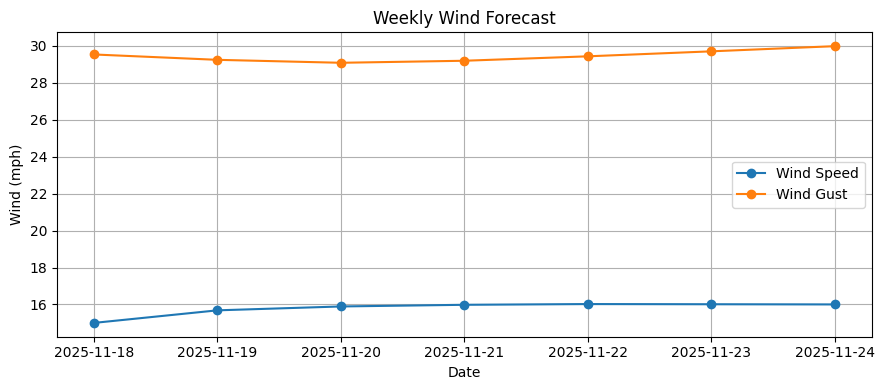

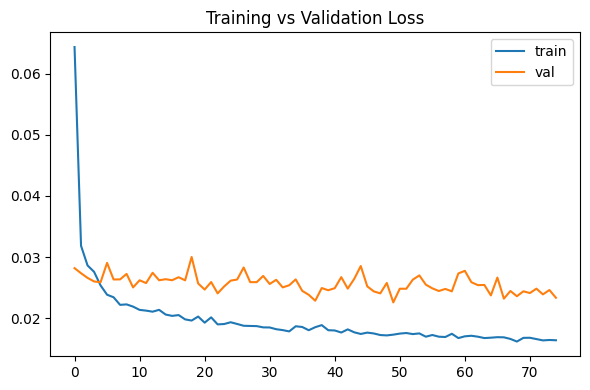

Saved artifact at '/tmp/tmp3p5_k1ma'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  139275057847696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139275064632208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139275064634896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139275069056848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139275068713936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139275075645904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139275057845776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139275069053392: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite multi-output model saved as weather_prediction_model.tflite


In [11]:
# === Weather Forecaster v6 by Amraj Takhar ===

# ------------------------------------------------------------------------------
# Import libraries and files needed for the Weather Forecaster.
# ------------------------------------------------------------------------------

csv_path = "/content/NYCDataset.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------------------
# Test if TensorFlow works. If not, use MLPRegressor
# ------------------------------------------------------------------------------

use_tensorflow = False
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras import optimizers
    use_tensorflow = True
except Exception:
    use_tensorflow = False

from sklearn.neural_network import MLPRegressor

# ------------------------------------------------------------------------------
# Loads and cleans the data in the csv file, proper formatting, chronological
# dates, numerical columns, etc.
# ------------------------------------------------------------------------------

df = pd.read_csv(csv_path)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.sort_values('datetime').reset_index(drop=True)
df = df[~df['datetime'].isna()].copy()

numeric_cols = ['temp','tempmax','tempmin','humidity','precip','precipprob',
                'windgust','windspeed','sealevelpressure']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
df['date'] = df['datetime'].dt.date

# ------------------------------------------------------------------------------
# What features/targets (inputs/outputs) is my model using. Also prevents high
# precipatation values from skewing the model predictions.
# ------------------------------------------------------------------------------

features = [f for f in ['temp','tempmax','tempmin','humidity','precip','windspeed','windgust','sealevelpressure', 'precipprob']
            if f in df.columns]
base_targets = [f for f in ['precip','humidity','sealevelpressure','windspeed','windgust'] if f in df.columns]
temp_targets_present = [c for c in ['temp','tempmax','tempmin'] if c in df.columns]

targets = base_targets + temp_targets_present
output_names_map = {
    'temp': 'avg_temp',
    'tempmax': 'max_temp',
    'tempmin': 'min_temp'
}
output_column_names = [output_names_map[t] if t in output_names_map else t for t in targets]

print("Features:", features)
print("Targets (model will predict):", output_column_names)

data = df[['datetime'] + features].copy().reset_index(drop=True)
if 'precip' in data.columns:
    data['precip'] = np.clip(data['precip'], 0, np.percentile(data['precip'], 99))

# ------------------------------------------------------------------------------
# Preparing the data for time-series modeling. Window size looks back 14 days.
# 14 days is best, doesn't decrease val_loss much. Also prints how many
# training samples/features/outputs there are
# ------------------------------------------------------------------------------

window_size = 14
X_list, y_list, dt_list = [], [], []

for i in range(len(data) - window_size):
    window = data.loc[i:i+window_size-1, features].values
    X_list.append(window.copy())
    y_list.append(data.loc[i+window_size, targets].values)
    dt_list.append(data.loc[i+window_size, 'datetime'])

X_seq = np.array(X_list)
y = np.array(y_list)
print(f"Training samples: {len(X_seq)} | Window size: {window_size} | Features per step: {len(features)} | Outputs: {len(targets)}")

# ------------------------------------------------------------------------------
# If not enough data, fallback to easier model predictions. Results may vary.
# ------------------------------------------------------------------------------
MIN_SAMPLES = 50
today = pd.Timestamp.today().normalize().date()
future_dates = [today + timedelta(days=i) for i in range(7)]

if X_seq.shape[0] < MIN_SAMPLES:
    print("\nNot enough samples for ML models. Using persistence fallback.")
    last_row = data.iloc[-1]
    persistence_preds = pd.DataFrame({
        'date': future_dates,
        **{output_names_map.get(t, t): [float(last_row[t])]*7 for t in targets}
    }).round(2)
    if 'precip' in persistence_preds.columns:
        max_rain = max(persistence_preds['precip'].max(), 0.5)
        persistence_preds['rain_chance_%'] = np.clip(100*persistence_preds['precip']/max_rain, 0, 100).round(2)
    display(persistence_preds)

# ------------------------------------------------------------------------------
# Split, Scale data features + outputs.
# ------------------------------------------------------------------------------

else:
    split_idx = int(0.8 * len(X_seq))
    X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    N_train = X_train_seq.shape[0]
    n_features = X_train_seq.shape[2]
    X_train_flat = X_train_seq.reshape(N_train, window_size * n_features)
    X_test_flat = X_test_seq.reshape(X_test_seq.shape[0], window_size * n_features)

    scaler_X = MinMaxScaler().fit(X_train_flat)
    X_train_s = scaler_X.transform(X_train_flat)
    X_test_s = scaler_X.transform(X_test_flat)

    scaler_y = MinMaxScaler().fit(y_train)
    y_train_s = scaler_y.transform(y_train)
    y_test_s = scaler_y.transform(y_test)

# ------------------------------------------------------------------------------
# We got 50 or more samples, so time to actually predict.
# ------------------------------------------------------------------------------

    if use_tensorflow:
        print("\nUsing TensorFlow LSTM model.")
        X_train_seq_s = X_train_s.reshape(-1, window_size, n_features)
        X_test_seq_s = X_test_s.reshape(-1, window_size, n_features)

        tf.keras.backend.clear_session()
        model = keras.Sequential([
            layers.Input(shape=(window_size, n_features)),
            layers.LSTM(128, activation='tanh', dropout=0.2),
            layers.Dense(48, activation='relu'),
            layers.Dense(len(targets), activation='linear')
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        early = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=25,
            min_delta=1e-4,
            restore_best_weights=True,
            verbose=1
        )

        history = model.fit(
            X_train_seq_s, y_train_s,
            validation_split=0.15,
            epochs=100,
            batch_size=32,
            callbacks=[early],
            verbose=1
        )

        print(f"\nTraining stopped after {len(history.history['loss'])} epochs.")
        y_pred_s = model.predict(X_test_seq_s)
        y_pred = scaler_y.inverse_transform(y_pred_s)

        last_window = data[features].iloc[-window_size:].values.copy()
        future_preds = []
        for _ in range(7):
            flat = last_window.flatten().reshape(1, -1)
            flat_s = scaler_X.transform(flat)
            flat_seq_s = flat_s.reshape(1, window_size, n_features)
            pred_s = model.predict(flat_seq_s).ravel()
            pred = scaler_y.inverse_transform(pred_s.reshape(1, -1)).ravel()
            future_preds.append(pred)
            new_row = last_window[-1].copy()
            for idx, feat in enumerate(features):
                if feat in targets:
                    t_idx = targets.index(feat)
                    new_row[idx] = float(pred[t_idx])
            last_window = np.vstack([last_window[1:], new_row])

        future_preds = np.array(future_preds)
        pred_df = pd.DataFrame(future_preds, columns=targets)
        pred_df['date'] = future_dates
        pred_df = pred_df.rename(columns=output_names_map)
        numeric_cols_pred = pred_df.select_dtypes(include=np.number).columns
        pred_df[numeric_cols_pred] = pred_df[numeric_cols_pred].round(2)

        # ======================================================================
        # If Tensorflow stops working, use MLPRegressor to train the model.
        # ======================================================================

    else:
        print("\nTensorFlow not available. Training MLPRegressor fallback on flattened windows.")
        mlp = MLPRegressor(hidden_layer_sizes=(256,128), activation='relu', max_iter=400, random_state=42, early_stopping=True)
        mlp.fit(X_train_s, y_train_s)
        y_pred_s = mlp.predict(X_test_s)
        y_pred = scaler_y.inverse_transform(y_pred_s)

        last_window = data[features].iloc[-window_size:].values.copy()
        future_preds = []
        for _ in range(7):
            flat = last_window.flatten().reshape(1, -1)
            flat_s = scaler_X.transform(flat)
            pred_s = mlp.predict(flat_s).ravel()
            pred = scaler_y.inverse_transform(pred_s.reshape(1, -1)).ravel()
            future_preds.append(pred)
            new_row = last_window[-1].copy()
            for idx, feat in enumerate(features):
                if feat in targets:
                    t_idx = targets.index(feat)
                    new_row[idx] = float(pred[t_idx])
            last_window = np.vstack([last_window[1:], new_row])

        future_preds = np.array(future_preds)
        pred_df = pd.DataFrame(future_preds, columns=targets)
        pred_df['date'] = future_dates
        pred_df = pred_df.rename(columns=output_names_map)
        numeric_cols_pred = pred_df.select_dtypes(include=np.number).columns
        pred_df[numeric_cols_pred] = pred_df[numeric_cols_pred].round(2)

    # ============================================================
    # Per-Target Error Breakdown
    # ============================================================
    print("\n=== Per-Target Error Breakdown ===")

    y_test_df = pd.DataFrame(y_test, columns=targets)
    y_pred_df = pd.DataFrame(y_pred, columns=targets)

    for col in targets:
        col_mae = mean_absolute_error(y_test_df[col], y_pred_df[col])
        col_rmse = np.sqrt(mean_squared_error(y_test_df[col], y_pred_df[col]))
        print(f"{col:16s} | MAE = {col_mae:6.3f} | RMSE = {col_rmse:6.3f}")

    # ============================================================
    # Calculate Rain Chance !!!!!!!!!!!!!!!!!!!!!!!!!!!
    # ============================================================

    if 'precip' in pred_df.columns:
      max_rain = max(pred_df['precip'].max(), 0.5)
      pred_df['rain_chance_%'] = np.clip(100*pred_df['precip']/max_rain, 0, 100).round(2)

    # ============================================================
    # Makes a good looking table.
    # ============================================================

    print("\n=== Weekly Forecast Summary ===")

    numeric_cols_pred = pred_df.select_dtypes(include=np.number).columns
    pred_df[numeric_cols_pred] = pred_df[numeric_cols_pred].round(2)
    pd.options.display.float_format = '{:.2f}'.format

    display(pred_df[['date'] + [c for c in pred_df.columns if c != 'date']])

    temp_cols_out = [output_names_map.get(c, c) for c in ['temp','tempmax','tempmin'] if c in targets]
    temp_df = pred_df[['date'] + temp_cols_out].copy().rename(columns={
        output_names_map.get('temp','temp'): 'avg_temp',
        output_names_map.get('tempmax','tempmax'): 'max_temp',
        output_names_map.get('tempmin','tempmin'): 'min_temp'
    })
    temp_df = temp_df.rename(columns=lambda s: s)
    display(temp_df)

    # --------------------------------------------------------------------------
    # Create all the plots. Temp, rain, humidity, pressure, wind.
    # --------------------------------------------------------------------------

    # Temp Plot
    plt.figure(figsize=(9,4))
    for col in ['avg_temp','max_temp','min_temp']:
        if col in temp_df.columns:
            plt.plot(temp_df['date'].astype(str), temp_df[col], marker='o', label=col.replace('_',' ').title())
    plt.title("Weekly Temperature Forecast (°F)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°F)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Rain Chance
    if 'rain_chance_%' in pred_df.columns:
        plt.figure(figsize=(9,4))
        plt.plot(pred_df['date'].astype(str), pred_df['rain_chance_%'], marker='o')
        plt.title("Weekly Predicted Rain Chance")
        plt.xlabel("Date")
        plt.ylabel("Rain Chance (%)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # humidity and pressure plots
    for col in ['humidity','sealevelpressure']:
        if col in pred_df.columns:
            plt.figure(figsize=(9,4))
            plt.plot(pred_df['date'].astype(str), pred_df[col], marker='o')
            plt.title(f"Weekly Forecast: {col.capitalize()}")
            plt.xlabel("Date")
            plt.ylabel(col.capitalize())
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Wind speed and gust
    plt.figure(figsize=(9,4))
    if 'windspeed' in pred_df.columns:
        plt.plot(pred_df['date'].astype(str), pred_df['windspeed'], marker='o', label='Wind Speed')
    if 'windgust' in pred_df.columns:
        plt.plot(pred_df['date'].astype(str), pred_df['windgust'], marker='o', label='Wind Gust')
    plt.title("Weekly Wind Forecast")
    plt.xlabel("Date")
    plt.ylabel("Wind (mph)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot training/validation loss
    if use_tensorflow and 'history' in globals():
        plt.figure(figsize=(6,4))
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.legend()
        plt.title("Training vs Validation Loss")
        plt.tight_layout()
        plt.show()

    # TFLite export
    if use_tensorflow:
        try:
            converter = tf.lite.TFLiteConverter.from_keras_model(model)
            converter.experimental_new_converter = True
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS
            ]
            tflite_model = converter.convert()
            with open('weather_prediction_model.tflite', 'wb') as f:
                f.write(tflite_model)
            print("TFLite multi-output model saved as weather_prediction_model.tflite")
        except Exception as e:
            print("TFLite export failed:", e)